In [1]:
!pip3 install torch torchvision torchaudio


Defaulting to user installation because normal site-packages is not writeable


In [1]:
!pip install --user \
seaborn==0.11.2 \
silx==1.1.2 \
numba==0.57.0 \
numpy==1.24.4 \
cython==0.29.30 \
blosc2==2.0.0 \
triton \
energyflow \
vector \
awkward \
uproot 

In [49]:
import os
import time
import numpy as np
import math 
import sys
import glob
from collections import defaultdict

import functools

import socket 

import matplotlib.pyplot as plt
import sklearn
import scipy
from scipy.sparse import csr_matrix

# Data analysis and plotting
import pandas as pd
import seaborn as sns
import uproot
import h5py


import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset


#import sklearn
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split

import networkx
import energyflow

print(f'sys.path = {sys.path}') 

# Define the path to your local repository
kan_repo_path = '/global/homes/d/dimathan/Kolmogorov-Arnold-for-QCD'

# Insert the local path at the beginning of sys.path
if kan_repo_path not in sys.path:
    sys.path.insert(0, kan_repo_path)
    from kan.KAN import KAN


import random




sys.path = ['/global/homes/d/dimathan/KAN-playground/', '/global/u2/d/dimathan/GNNs-and-Jets/analysis', '/global/common/software/nersc/pe/conda-envs/24.1.0/python-3.11/nersc-python/lib/python311.zip', '/global/common/software/nersc/pe/conda-envs/24.1.0/python-3.11/nersc-python/lib/python3.11', '/global/common/software/nersc/pe/conda-envs/24.1.0/python-3.11/nersc-python/lib/python3.11/lib-dynload', '', '/global/homes/d/dimathan/.local/perlmutter/python-3.11/lib/python3.11/site-packages', '/global/common/software/nersc/pe/conda-envs/24.1.0/python-3.11/nersc-python/lib/python3.11/site-packages']


In [9]:
model_info = {
        'output_dir': '/pscratch/sd/d/dimathan/OT/test_output',
        'n_total': 10000,
        'n_train': 8000, 
        'n_test': 2000,
        'n_val': 0,
        'model_settings': {
            'epochs':5,
            'learning_rate':0.0003,
            'batch_size':512,
            'K': 2,
            'N_cluster': 2,
            'load_model': False}
    }

torch_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'torch_device: {torch_device}')

output_dir = model_info['output_dir']

n_total = model_info['n_total']
n_train = model_info['n_train']
n_test = model_info['n_test']
n_val = model_info['n_val'] 
test_frac = n_test/n_total
val_frac = n_val/n_total

batch_size = model_info['model_settings']['batch_size']
learning_rate = model_info['model_settings']['learning_rate']
epochs = model_info['model_settings']['epochs']
K = model_info['model_settings']['K']
N_cluster = model_info['model_settings']['N_cluster']
load_model = model_info['model_settings']['load_model']


torch_device: cuda


In [10]:
output = defaultdict(list)
classification_task = 'ZvsQCD'

# Load the nsubjettiness features
if classification_task == 'qvsg': 
    if N_cluster in [2, 3, 5, 7, 10, 15]:
        path = '/pscratch/sd/d/dimathan/GNN/exclusive_subjets_200k/subjets_unshuffled.h5'
    elif N_cluster in [4, 6, 8]:
        path = '/pscratch/sd/d/dimathan/GNN/exclusive_subjets_qvsg_200k_N468/subjets_unshuffled.h5'
    else: 
        path = '/pscratch/sd/d/dimathan/GNN/exclusive_subjets_qvsg_200k_N203040506080100/subjets_unshuffled.h5'
elif classification_task == 'ZvsQCD':
    if N_cluster in [2, 3, 4, 5, 6, 7, 8, 10, 15]:
        path = '/pscratch/sd/d/dimathan/GNN/exclusive_subjets_ZvsQCD_200k_N23456781015/subjets_unshuffled.h5'
    else:
        path = '/pscratch/sd/d/dimathan/GNN/exclusive_subjets_ZvsQCD_200k_N203040506080100/subjets_unshuffled.h5'

with h5py.File(path, 'r') as hf:
    X_nsub = np.array(hf[f'nsub_subjet_N{N_cluster}'])[:n_total, :3*(K-1)-1]
    Y = hf[f'y'][:n_total]

      
print('loaded from file')
print()

print(f'X_nsub.shape: {X_nsub.shape}')
print(f'Y.shape: {Y.shape}')

# print the first 5 rows of X_nsub and Y
#print(f'X_nsub[:10]: {X_nsub[:10]}')
#print(f'Y[:10]: {Y[:10]}')
# how many of each class in Y: 
print(f'Y class counts: {np.sum(Y == 0)}, {np.sum(Y == 1)}')


loaded from file

X_nsub.shape: (10000, 2)
Y.shape: (10000,)
Y class counts: 5000, 5000


In [11]:
    #---------------------------------------------------------------
    def shuffle_and_split(X, Y, test_ratio=0.1, val_ratio=0.1):
        """
        Shuffles and splits the data into training, validation, and test sets.

        Parameters:
        - X: Features.
        - Y: Targets/Labels.
        - train_ratio: Proportion of the dataset to include in the train split.
        - test_ratio: Proportion of the dataset to include in the test split.
        - val_ratio: Proportion of the dataset to include in the validation split.
        - random_seed: The seed used by the random number generator.

        Returns:
        - X_train, Y_train: Training set.
        - X_val, Y_val: Validation set.
        - X_test, Y_test: Test set.
        """

        # First, split into training and temp (test + validation) sets
        X_train, X_temp, Y_train, Y_temp = train_test_split(
            X, Y, test_size=(test_ratio + val_ratio))

        # Now split the temp set into actual test and validation sets
        #test_size_proportion = test_ratio / (test_ratio + val_ratio)
        #X_val, X_test, Y_val, Y_test = train_test_split(
        #    X_temp, Y_temp, test_size=test_size_proportion)

        return X_train, Y_train, X_temp, Y_temp


In [12]:
# shuffle X_nsub and self.Y and split into training/test/validation sets
X_train, Y_train, X_test, Y_test = shuffle_and_split(X_nsub, Y, test_ratio=test_frac, val_ratio=val_frac)   

# split the training data into batches of size 64

train_data = TensorDataset(torch.tensor(X_train).float(), torch.tensor(Y_train).float().view(-1, 1))
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True) 
        
test_data = TensorDataset(torch.tensor(X_test).float(), torch.tensor(Y_test).float().view(-1, 1))
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# We now have to conform to the KAN input format, which is a dataset dictionary that contains: 'train_input', 'test_input', 'train_label', 'test_label'
# Concatenate all data into a single tensor on the specified device

train_inputs = torch.empty(0, X_nsub.shape[1], device=torch_device)
train_labels = torch.empty(0, dtype=torch.long, device=torch_device)
test_inputs = torch.empty(0, X_nsub.shape[1], device=torch_device)
test_labels = torch.empty(0, dtype=torch.long, device=torch_device)

for data, labels in train_loader:
    train_inputs = torch.cat((train_inputs, data.to(torch_device)), dim=0)
    train_labels = torch.cat((train_labels, labels.to(torch_device)), dim=0)

for data, labels in test_loader:
    test_inputs = torch.cat((test_inputs, data.to(torch_device)), dim=0)
    test_labels = torch.cat((test_labels, labels.to(torch_device)), dim=0)


dataset = {}
dataset['train_input'] = train_inputs
dataset['test_input'] = test_inputs
dataset['train_label'] = train_labels.view(-1, 1)
dataset['test_label'] = test_labels.view(-1, 1)
print('dataset size:', len(dataset['train_input']) )

dataset size: 8000


In [13]:
def train_acc():
    with torch.no_grad():
        predictions = model(dataset['train_input'])
        correct = (predictions > 0.).float() == dataset['train_label'].float()
        accuracy = torch.mean(correct.float())
    return accuracy

def test_acc():
    with torch.no_grad():
        predictions = model(dataset['test_input'])
        correct = (predictions > 0.).float() == dataset['test_label'].float()
        accuracy = torch.mean(correct.float())
    return accuracy

def train_auc_score():
    with torch.no_grad():
        predictions = model(dataset['train_input'])
        auc = roc_auc_score(dataset['train_label'].cpu(), predictions.cpu())
    return auc

def test_auc_score():
    with torch.no_grad():
        predictions = model(dataset['test_input'])
        auc = roc_auc_score(dataset['test_label'].cpu(), predictions.cpu())
    return auc



KAN(
  (biases): ModuleList(
    (0): Linear(in_features=5, out_features=1, bias=False)
    (1): Linear(in_features=1, out_features=1, bias=False)
  )
  (act_fun): ModuleList(
    (0-1): 2 x KANLayer(
      (base_fun): SiLU()
    )
  )
  (base_fun): SiLU()
  (symbolic_fun): ModuleList(
    (0-1): 2 x Symbolic_KANLayer()
  )
)
Total number of parameters: 306



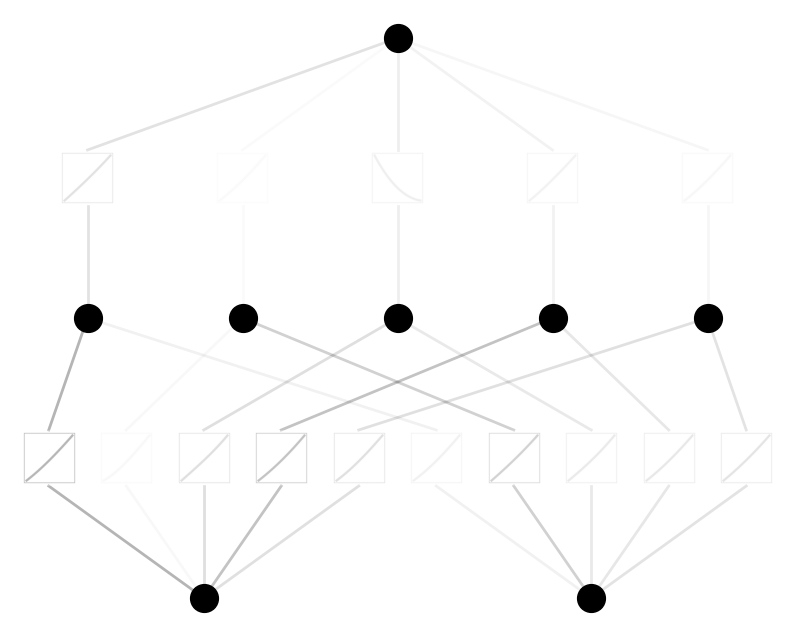

In [14]:
model = KAN(width=[X_nsub.shape[1], 5, 1], grid = 4, k = 3, device = torch_device)
model = model.to(torch_device)

# Print the model architecture
print()
print(model)
print(f'Total number of parameters: {sum(p.numel() for p in model.parameters())}')
print()

# plot the model: Do a forward pass to generate the graph (no training occurs for this)
model(dataset['train_input'])
fig = model.plot(beta=10, scale=1)


In [20]:
time_start = time.time()
criterion = nn.BCEWithLogitsLoss()
results = model.train(dataset, opt = 'Adam', lamb=0.001, lamb_l1=1., lr = 0.01, loss_fn = criterion, device = torch_device, steps = 100, \
                      update_grid=True, grid_update_num=20, stop_grid_update_step=200, metrics=(train_acc, test_acc, train_auc_score, test_auc_score), \
                      save_fig=True, img_folder='./video', batch = batch_size)

train loss: 6.62e-01 | test loss: 7.03e-01 | reg: 1.57e+01 : 100%|█| 100/100 [03:05<00:00,  1.86s/it


In [21]:
print(f"results")
print(results)
print()
print(f"train_acc: {results['train_acc'][-1]}")
print(f"test_acc: {results['test_acc'][-1]}")
print(f"train_auc: {results['train_auc_score'][-1]}")
print(f"test_auc: {results['test_auc_score'][-1]}")
# keep the max test auc
print(f'====================================================================')
print(f"max test auc: {max(results['test_auc_score'])}")
print(f'====================================================================')
print()

results
{'train_loss': [array(0.66241515, dtype=float32), array(0.6760049, dtype=float32), array(0.63350326, dtype=float32), array(0.72747415, dtype=float32), array(0.72376704, dtype=float32), array(0.6899923, dtype=float32), array(0.6873924, dtype=float32), array(0.70452034, dtype=float32), array(0.6923078, dtype=float32), array(0.6369938, dtype=float32), array(0.64609885, dtype=float32), array(0.69107294, dtype=float32), array(0.66033006, dtype=float32), array(0.6600399, dtype=float32), array(0.64299446, dtype=float32), array(0.6882511, dtype=float32), array(0.6595392, dtype=float32), array(0.6802984, dtype=float32), array(0.67006135, dtype=float32), array(0.6743147, dtype=float32), array(0.64506775, dtype=float32), array(0.6443512, dtype=float32), array(0.6649106, dtype=float32), array(0.6723087, dtype=float32), array(0.67341954, dtype=float32), array(0.66515845, dtype=float32), array(0.6772066, dtype=float32), array(0.6635361, dtype=float32), array(0.67237055, dtype=float32), array

In [22]:
train_loss = []
for index, arr in enumerate(results['train_auc_score']):
    print(index, arr)
    train_loss.append(arr) 
print(train_loss)

0 0.8583193583193582
1 0.8674013674013675
2 0.864541552041552
3 0.8618021743021743
4 0.8647595835095836
5 0.8667079292079293
6 0.8656519281519282
7 0.8647031147031149
8 0.8647277397277396
9 0.865060708810709
10 0.8631283006283007
11 0.8656502406502407
12 0.8675349925349926
13 0.8678383678383679
14 0.866285085035085
15 0.8665518665518666
16 0.86866664991665
17 0.8702810577810578
18 0.8709320584320586
19 0.8710839335839335
20 0.8713097463097463
21 0.871726652976653
22 0.8713500588500589
23 0.870404057904058
24 0.8693966506466507
25 0.8704181204181203
26 0.8710651210651211
27 0.8712615587615588
28 0.8714491526991528
29 0.8702733702733703
30 0.8704149954149953
31 0.871958871958872
32 0.8731484356484356
33 0.8729586542086542
34 0.8709695584695585
35 0.8708222458222459
36 0.8721389971389971
37 0.8729931542431542
38 0.8735535923035922
39 0.8717351842351844
40 0.8698469948469949
41 0.8711315586315587
42 0.8723477785977787
43 0.8725938725938726
44 0.8725551850551851
45 0.8725898725898726
46 0.8

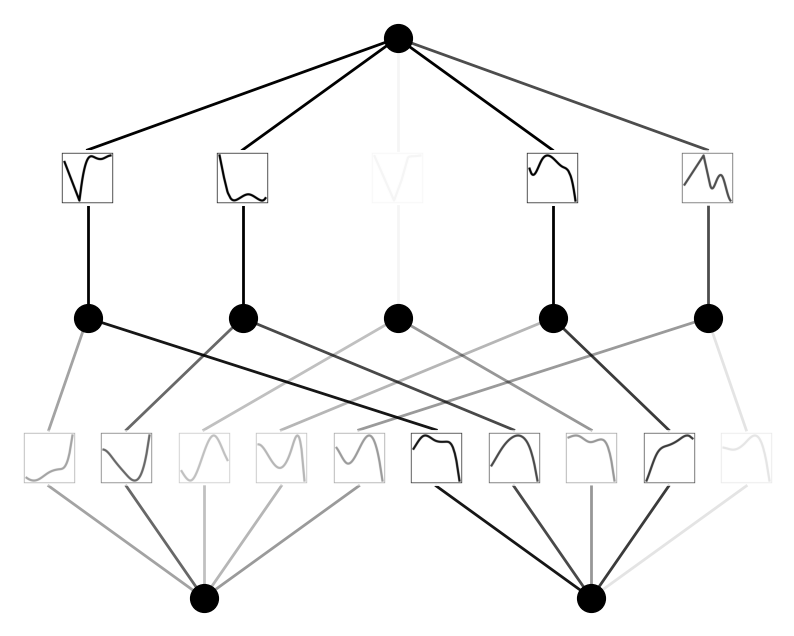

In [23]:
fig_final = model.plot(scale = 1)

In [47]:
pruned_model = model.prune(threshold = 0.3)

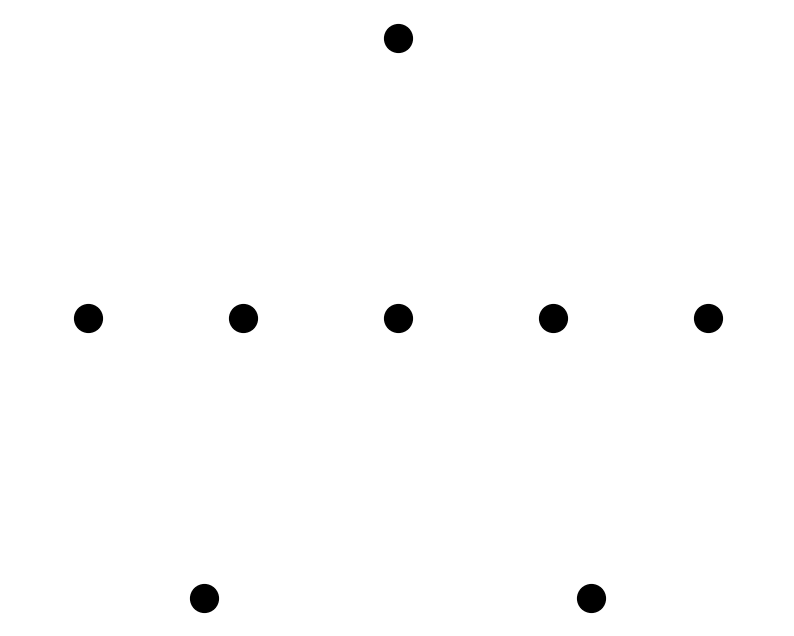

In [48]:
fig_pruned = model.plot(scale = 1.)

In [30]:
predictions_pruned = pruned_model(dataset['test_input'])
auc_pruned = roc_auc_score(dataset['test_label'].cpu().detach().numpy(), predictions_pruned.cpu().detach().numpy())
print(f"auc_pruned: {auc_pruned}")
print(f'test accuracy pruned: {test_acc()}')
print()

auc_pruned: 0.8095859533752541
test accuracy pruned: 0.7385000586509705



In [297]:
model.suggest_symbolic(0,0,4)

function , r2
x^4 , 0.9637660384178162
gaussian , 0.9387803077697754
tanh , 0.9095911979675293
cosh , 0.9050582051277161
1/x^4 , 0.8930767774581909


('x^4',
 (<function kan.utils.<lambda>(x)>, <function kan.utils.<lambda>(x)>),
 0.9637660384178162)

In [298]:
model.fix_symbolic(0,0,4,'x^4')

r2 is 0.9637660384178162


tensor(0.9638, device='cuda:0')

In [151]:
model.suggest_symbolic(0,0,3)


function , r2
sin , 0.9998360276222229
gaussian , 0.9991617202758789
tanh , 0.9982911944389343
arctan , 0.9971104860305786
sigmoid , 0.9904738068580627


('sin',
 (<function kan.utils.<lambda>(x)>, <function kan.utils.<lambda>(x)>),
 0.9998360276222229)

In [128]:
model.fix_symbolic(0,1,0,'gaussian')

r2 is 0.9999750852584839


tensor(1.0000, device='cuda:0')

In [121]:
model.suggest_symbolic(1,0,0)


function , r2
abs , 1.000000238418579
gaussian , 0.9675634503364563
sin , 0.9571614265441895
x^2 , 0.8707295060157776
cosh , 0.8699889779090881


('abs',
 (<function kan.utils.<lambda>(x)>, <function kan.utils.<lambda>(x)>),
 1.000000238418579)

In [152]:
model.suggest_symbolic(0,1,0)

function , r2
gaussian , 0.9999462366104126
sin , 0.9999443888664246
tanh , 0.9995428323745728
sigmoid , 0.999542772769928
arctan , 0.9992303252220154


('gaussian',
 (<function kan.utils.<lambda>(x)>, <function kan.utils.<lambda>(x)>),
 0.9999462366104126)

In [153]:
model.fix_symbolic(0,1,0,'gaussian')

r2 is 0.9999462366104126


tensor(0.9999, device='cuda:0')

In [598]:
model.suggest_symbolic(1,1,0)


function , r2
abs , 0.913012683391571
gaussian , 0.8802832961082458
sin , 0.7886037230491638
x^2 , 0.7573620080947876
cosh , 0.7552286982536316


('abs',
 (<function kan.utils.<lambda>(x)>, <function kan.utils.<lambda>(x)>),
 0.913012683391571)

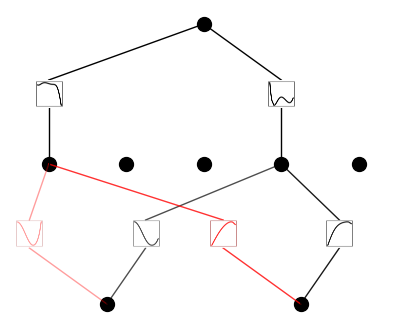

In [154]:
fig_symbolic = model.plot()

In [155]:
predictions_symbolic = model(dataset['test_input'])
auc_symbolic = roc_auc_score(dataset['test_label'].cpu().detach().numpy(), predictions_symbolic.cpu().detach().numpy())
print(f"auc_pruned: {auc_symbolic}")
print(f'test accuracy pruned: {test_acc()}')
print()

auc_pruned: 0.8504151660664265
test accuracy pruned: 0.7955000400543213



In [41]:
results_symbolic = model.train(dataset, opt = 'Adam', lr=0.1, loss_fn = criterion, device = torch_device, steps = 1000, metrics=(train_acc, test_acc, train_auc_score, test_auc_score), batch = batch_size)


train loss: 6.79e-01 | test loss: 6.73e-01 | reg: 3.14e+01 : 100%|█| 1000/1000 [00:46<00:00, 21.36it


In [42]:
#print(f"results_symbolic")
#print(results_symbolic)
print()
print(f"train_acc: {results_symbolic['train_acc'][-1]}")
print(f"test_acc: {results_symbolic['test_acc'][-1]}")
print(f"train_auc: {results_symbolic['train_auc_score'][-1]}")
print(f"test_auc: {results_symbolic['test_auc_score'][-1]}")
# keep the max test auc
print(f'====================================================================')
print(f"max test auc: {max(results_symbolic['test_auc_score'])}")
print(f'====================================================================')
print()


train_acc: 0.7981250286102295
test_acc: 0.7980000376701355
train_auc: 0.8576239826239827
test_auc: 0.8550846813549016
max test auc: 0.8653978463655418



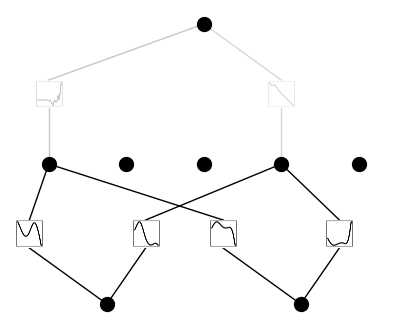

In [43]:
fig_pruned_symbolic = model.plot()

In [44]:
model.auto_symbolic()

fixing (0,0,0) with gaussian, r2=0.9418902397155762
fixing (0,0,1) with cosh, r2=0.0
fixing (0,0,2) with cosh, r2=0.0
fixing (0,0,3) with gaussian, r2=0.9958183169364929
fixing (0,0,4) with cosh, r2=0.0
fixing (0,1,0) with gaussian, r2=0.9207656383514404
fixing (0,1,1) with cosh, r2=0.0
fixing (0,1,2) with cosh, r2=0.0
fixing (0,1,3) with x^4, r2=0.9637408256530762
fixing (0,1,4) with cosh, r2=0.0
fixing (1,0,0) with gaussian, r2=0.9614050388336182
fixing (1,1,0) with cosh, r2=0.0
fixing (1,2,0) with cosh, r2=0.0
fixing (1,3,0) with tanh, r2=0.9065736532211304
fixing (1,4,0) with cosh, r2=0.0


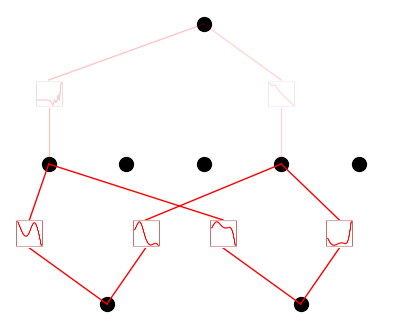

In [45]:
fig_pruned_autosymbolic = model.plot()

In [46]:
model.symbolic_formula(floating_digit=2)

([-5.96*tanh(1995.55*(0.18 - x_2)**4 - 3.06 + 0.83*exp(-70.56*(0.09 - x_1)**2)) - 7.79 + 3.48*exp(-50.4*(0.42 + 0.62*exp(-73.96*(0.17 - x_1)**2) - exp(-100.0*(0.1 - x_2)**2))**2)],
 [x_1, x_2])

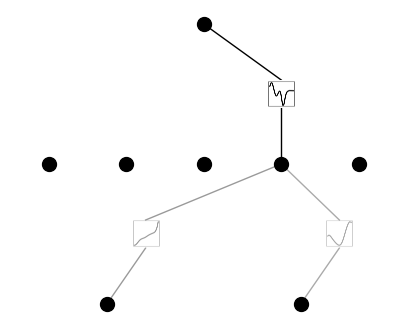

In [164]:
fig_pruned 